accept 1
accept 2
accept 3
[0 0 0 ... 0 0 0]
[[ 48 222 238]
 [238 238 238]
 [ 49  52  54]]


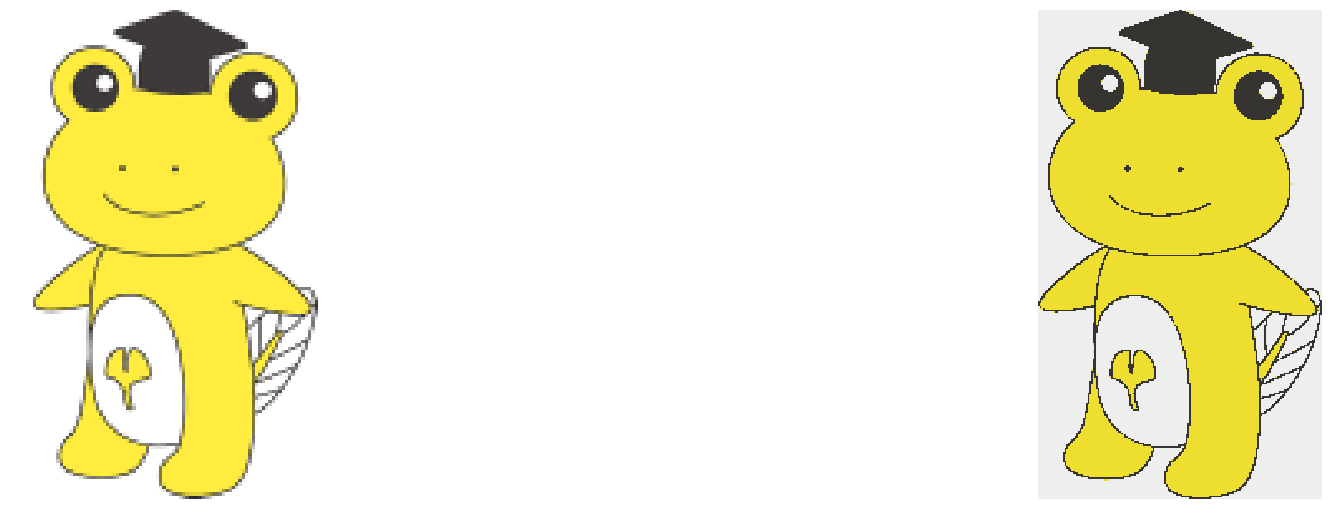

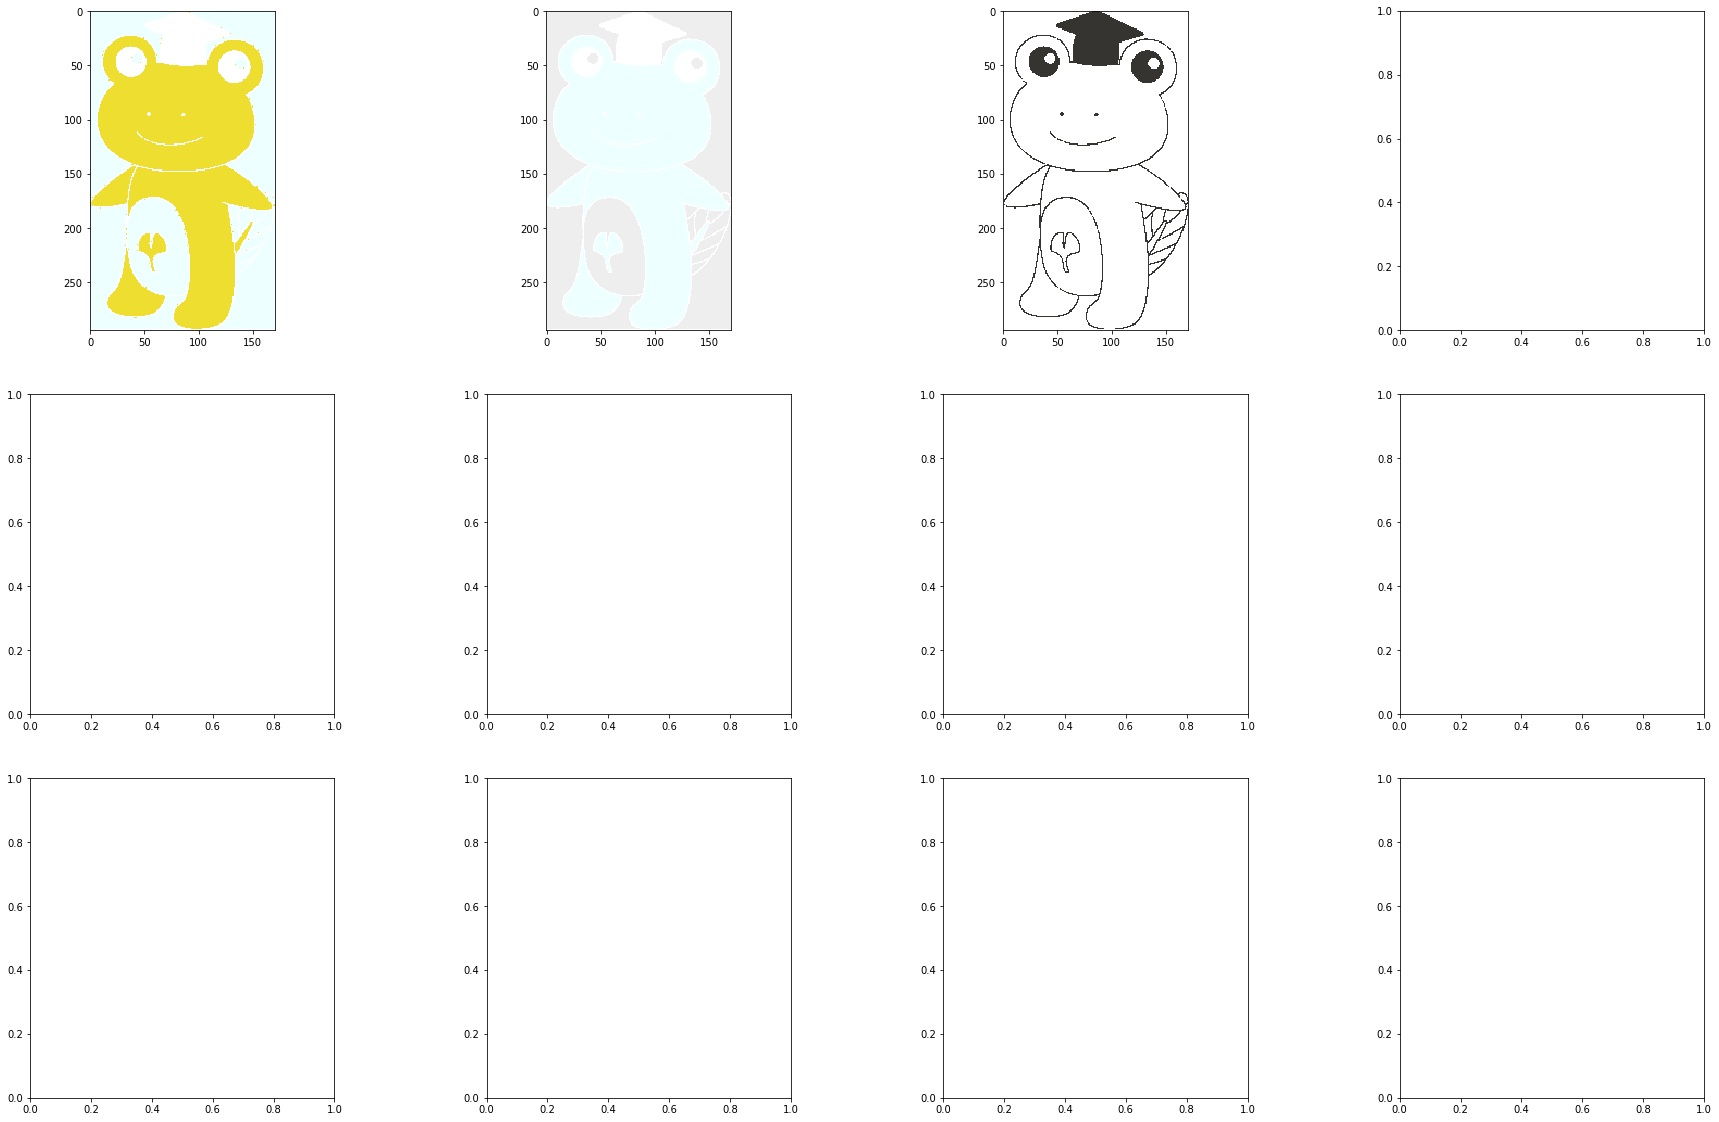

In [2]:
##改良版 ver2(16*16*16次元)

import cv2
import numpy as np
from matplotlib import pyplot as plt
import sys, time

import k_means as km
                
                
#img = cv2.imread('maskgan.png')
#img = cv2.imread('monster1.png')
#img = cv2.imread('pearl1.jpg')
#img = cv2.imread('baby1.png')
#img = cv2.imread('obama.png')
img = cv2.imread('komakkero.png')
#img = cv2.imread('cat.jpg')
#img = cv2.imread('puipui.jpg')
#img = cv2.imread('cat2.png')
#cv2.imshow('image', img)
colors = img.reshape(-1, 3)
K = 3
firstK = 3
loop = 100


#img = cv2.bilateralFilter(img, 20, sigmaColor=50, sigmaSpace=20)

##color->16*16*16
colors_bgr16 = (lambda e: e // 16)(colors)
colors_bgr16_aligned = np.apply_along_axis(km.make_align_bgr16, 1, colors_bgr16)
weight_bgr16, _ = np.histogram(colors_bgr16_aligned, bins=16*16*16, range=[0,16*16*16])

##k-means
#labels = [_ for _ in range(16*16*16)]
extracted_colors0, labels0_bgr16, diff_map0 \
    = km.k_means(loop, firstK, 0, weight_bgr16, [_ for _ in range(16*16*16)], 10)
updated_weight = (diff_map0 * weight_bgr16).astype(int)
print(updated_weight)
extracted_colors1, labels1_bgr16, diff_map1 \
    = km.k_means(loop, K-firstK, firstK, updated_weight, labels0_bgr16, 10)

labels=(np.frompyfunc((lambda e: labels1_bgr16[e]), 1, 1))(colors_bgr16_aligned)
extracted_colors = extracted_colors0
if (K > firstK):
    extracted_colors = np.concatenate([extracted_colors, extracted_colors1])

# 可視化する。
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(30, 9))
fig.subplots_adjust(wspace=0.5)


# 画像を表示する。
img_resize = cv2.resize(img,dsize=None, fx=0.5, fy=0.5)
ax1.imshow(cv2.cvtColor(img_resize, cv2.COLOR_BGR2RGB))
ax1.set_axis_off()

#目標
dst = extracted_colors[labels.astype(int)].reshape(img.shape) #type->unit8

dst = cv2.medianBlur(dst, 1)

km.smooth(dst)

ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_axis_off()


print(extracted_colors)

#maskの分類
dst_mask = [_ for i in range(K)]
colored_layers = []

fig, axes = plt.subplots(3, 4, figsize=(30, 20))
fig.subplots_adjust(wspace=0.5)
for i in range(K):
    dst_mask[i] = np.where(dst == extracted_colors[i], dst, np.array([255,255,255]).astype(np.uint8))
    km.white_padding(dst_mask[i])
    dst_mask_rgb = cv2.cvtColor(dst_mask[i], cv2.COLOR_BGR2RGB)
    axes[i//4][i%4].imshow(dst_mask_rgb)
    h, w = dst_mask[i].shape[0], dst_mask[i].shape[1]
    colored_layer = np.zeros((h,w))
    for x in range(h):
        for y in range(w):
            if (np.all(dst_mask[i][x,y] == extracted_colors[i])):
                colored_layer[x,y] = 1
    colored_layers.append(colored_layer)

plt.show()

In [19]:
###diff###
diff_map01 = diff_map0 / max(diff_map0)
diff_map11 = diff_map1 / max(diff_map1)
diff_map02 =(np.frompyfunc((lambda e: diff_map01[e]), 1, 1))(colors_bgr16_aligned)
diff_map12 =(np.frompyfunc((lambda e: diff_map11[e]), 1, 1))(colors_bgr16_aligned)
diff0 = diff_map02.reshape([img.shape[0],img.shape[1]])
diff1 = diff_map12.reshape([img.shape[0],img.shape[1]])
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(30, 9))
ax1.imshow((diff0*1000).astype(np.uint8))
ax3.imshow((diff1*1000).astype(np.uint8))
di0 = np.zeros([img.shape[0],img.shape[1], img.shape[2]])
di1 = np.zeros([img.shape[0],img.shape[1], img.shape[2]])
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        di0[i][j] = diff0[i][j]*img[i][j]
        di1[i][j] = diff1[i][j]*img[i][j]
ax2.imshow(cv2.cvtColor(di0.astype(np.uint8), cv2.COLOR_BGR2RGB))
ax4.imshow(cv2.cvtColor(di1.astype(np.uint8), cv2.COLOR_BGR2RGB))

normal_extracted_colors = np.apply_along_axis((lambda e: e / np.linalg.norm(e)),1,(extracted_colors))
#print(normal_extracted_colors)
#print(extracted_colors)

/Users/yuta/.pyenv/versions/anaconda3-5.3.0/envs/py3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ValueError: max() arg is an empty sequence

4.0
3.0
3.0


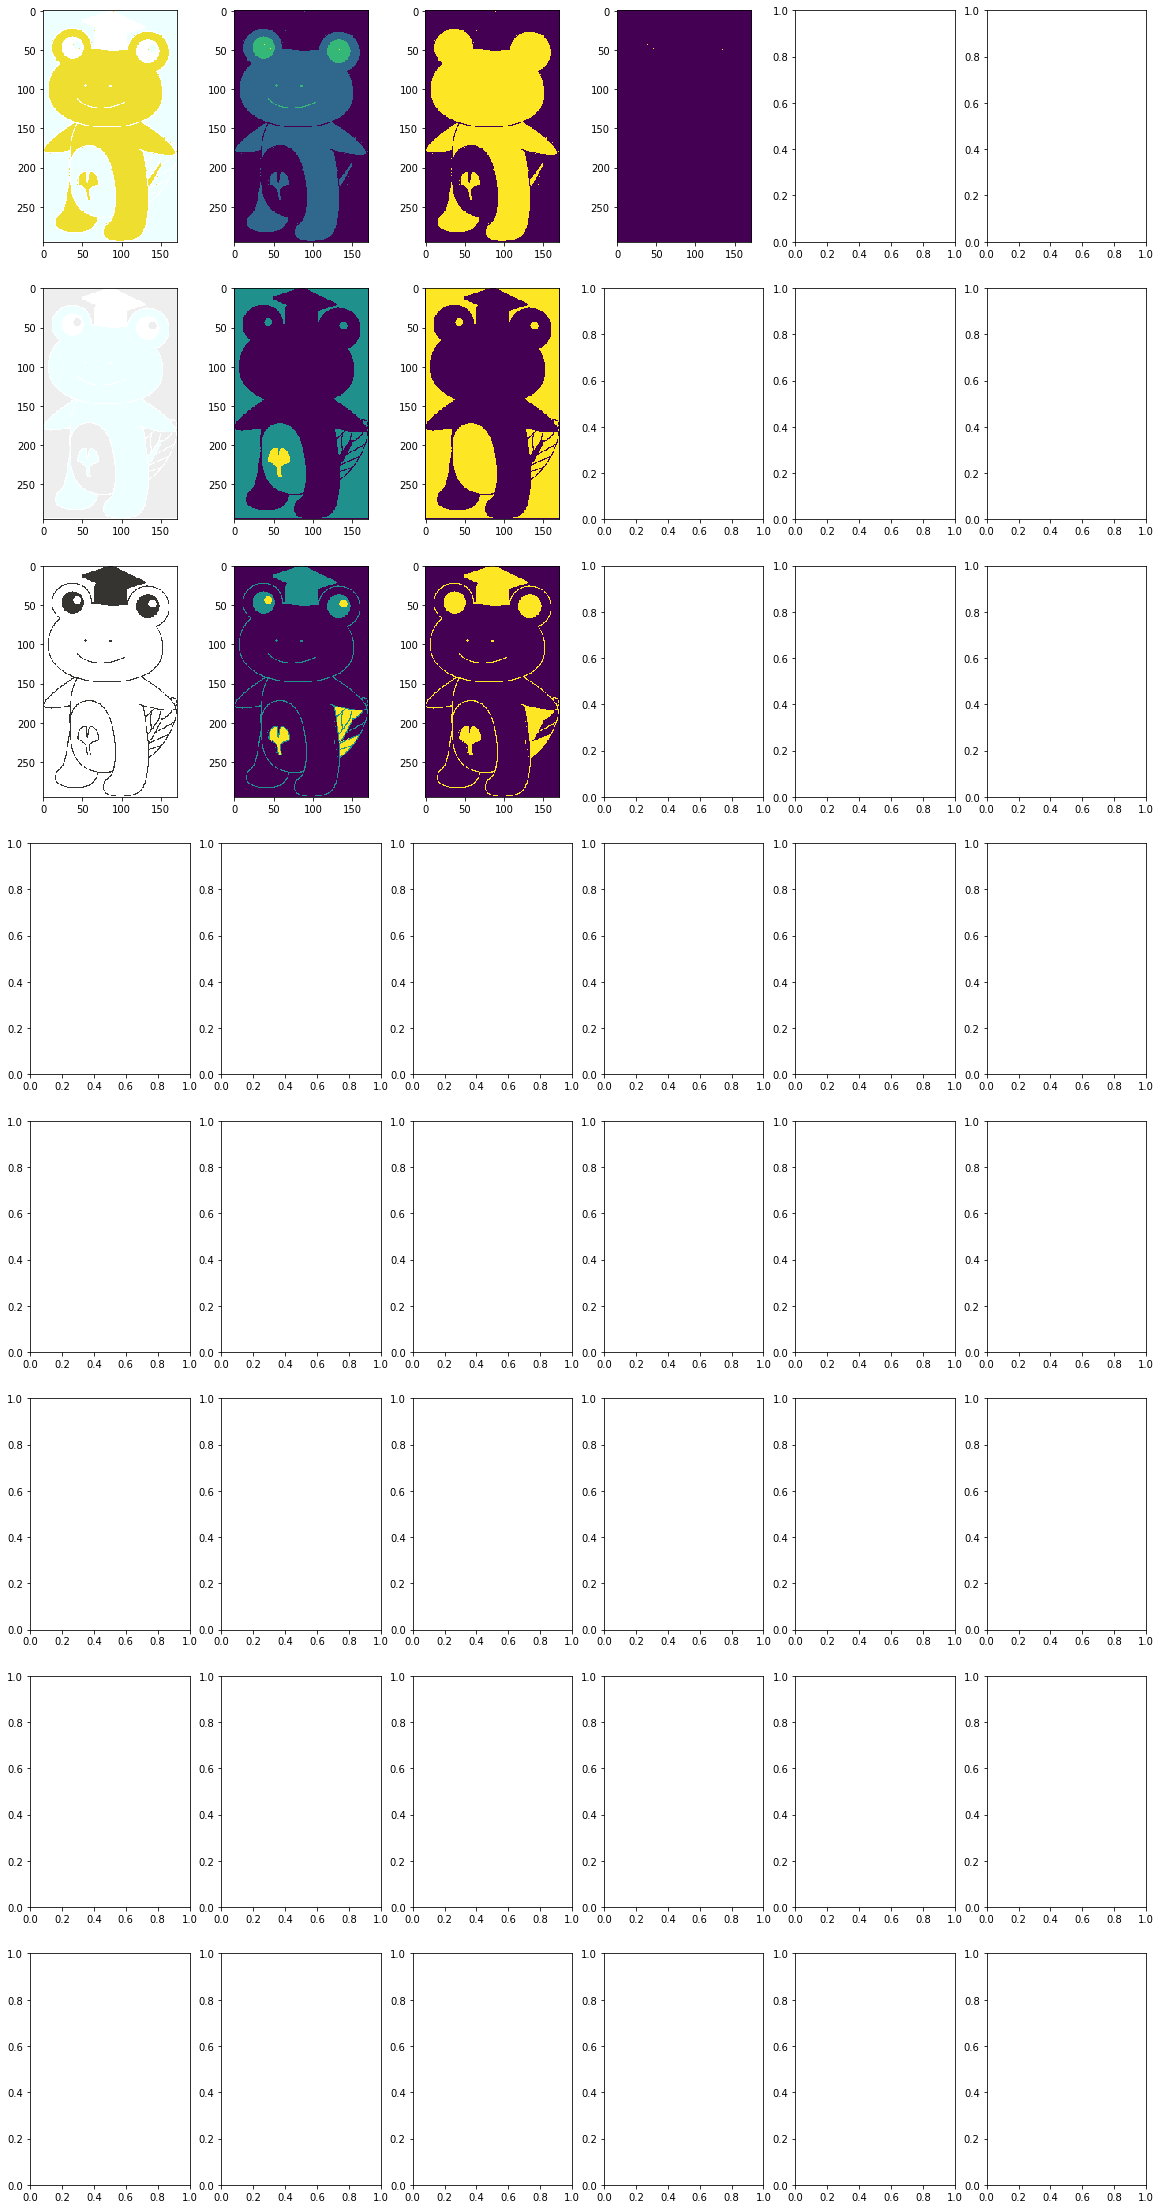

In [3]:
####live####
from collections import deque

import islands


island_labels = []
hole_lists = []

fig, axs = plt.subplots(8, 6, figsize=(20, 40))

for i in range(len(dst_mask)):
    dst_mask_rgb = cv2.cvtColor(dst_mask[i].astype(np.uint8), cv2.COLOR_BGR2RGB)
    island_labels.append(np.zeros((dst_mask[i].shape[0], dst_mask[i].shape[1])))
    count = islands.flood_fill_stack(colored_layers[i], island_labels[i])
    print(np.max(island_labels[i]))
    hole_lists.append(islands.make_hole_list(island_labels[i]))
    
    axs[i][0].imshow(dst_mask_rgb)
    axs[i][1].imshow(island_labels[i])
    for j in range(min(len(hole_lists[i]),4)):
        axs[i][2+j].imshow(hole_lists[i][j])

[[46, 50], [67], [137]] 137


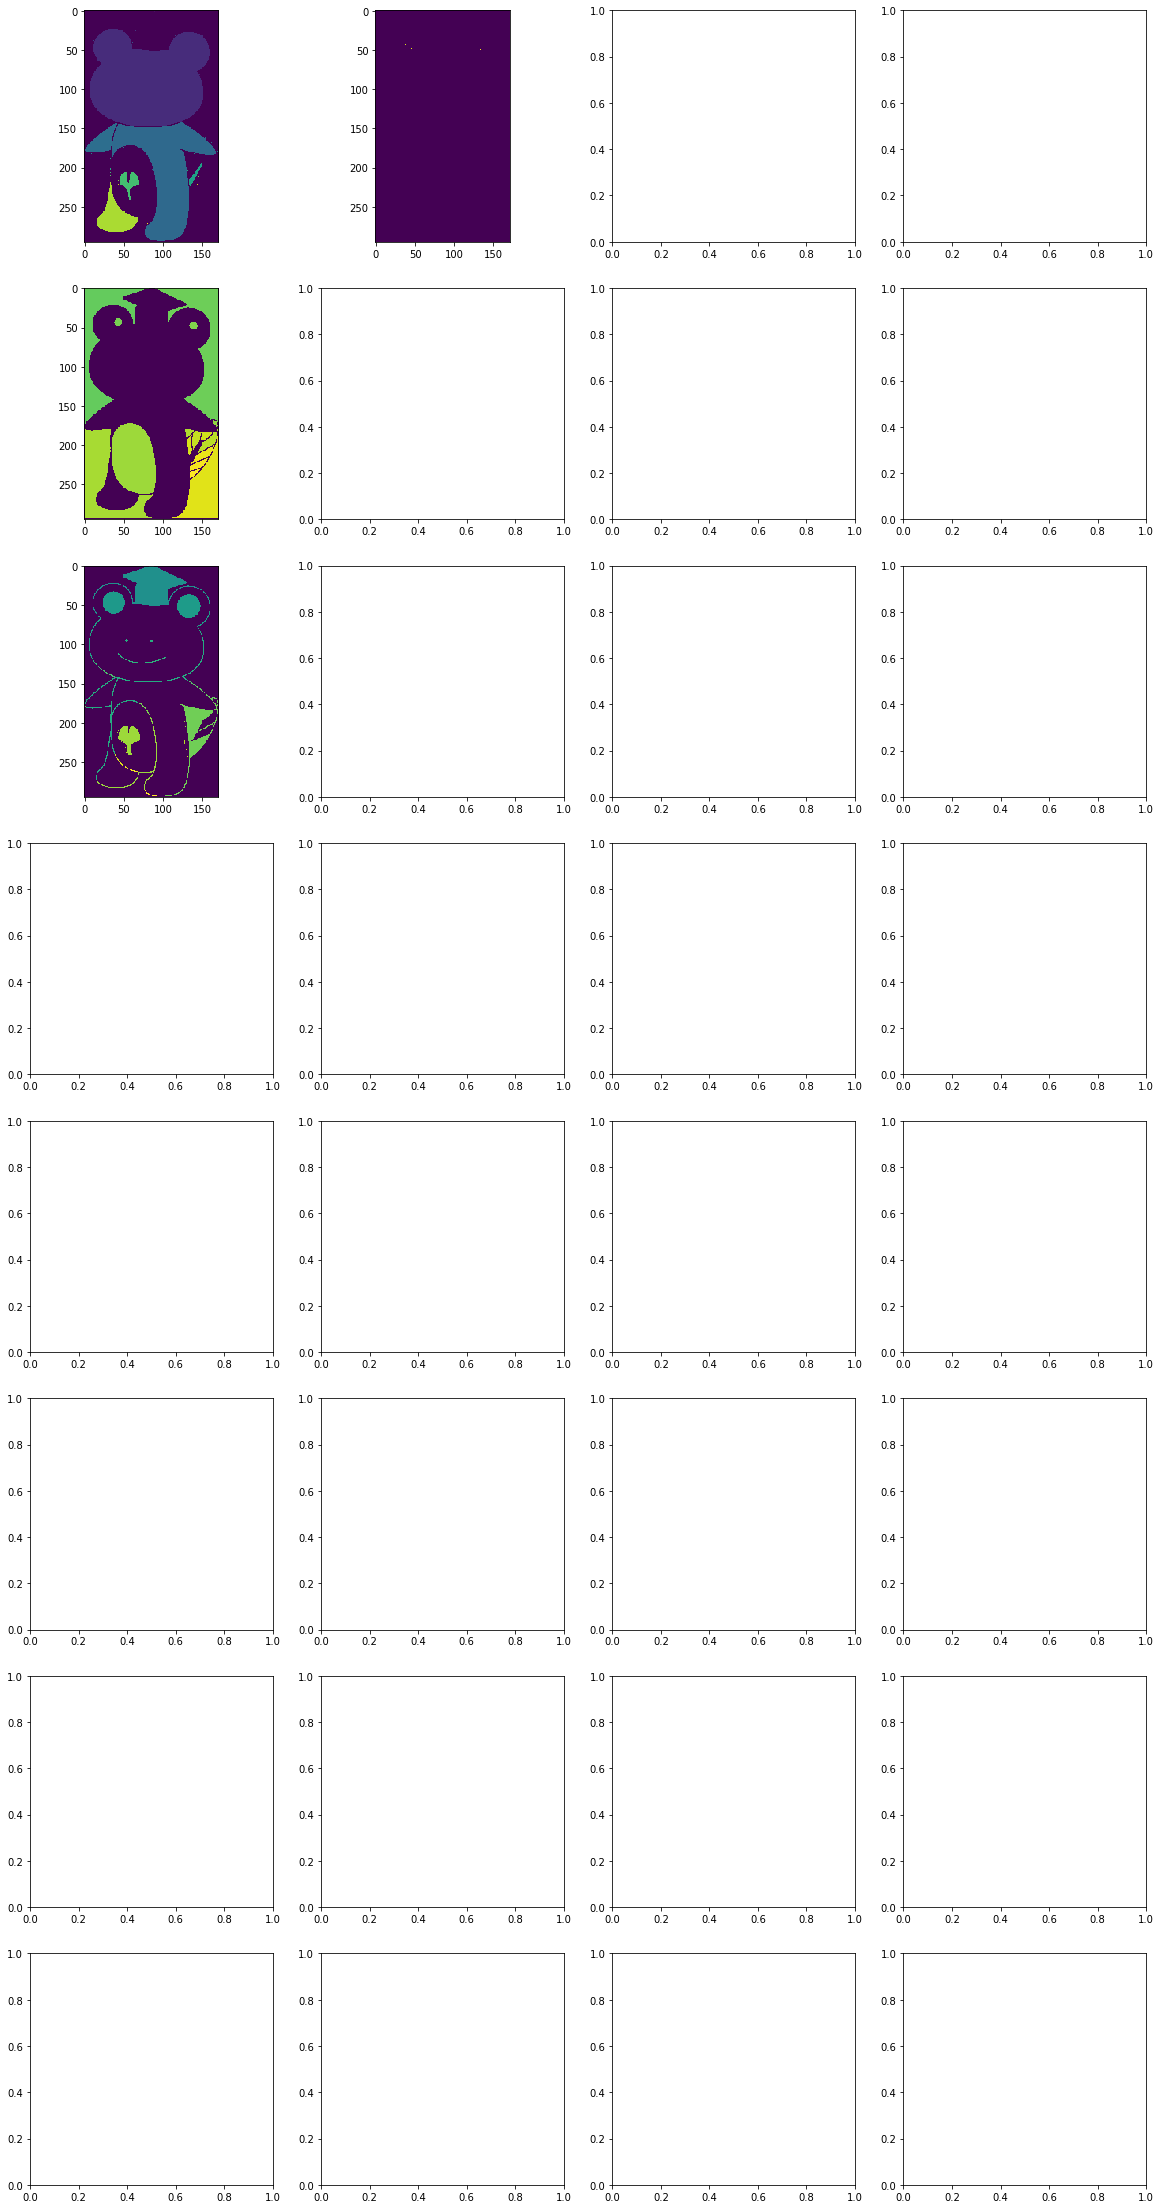

In [4]:
####live####
import copy

fig, axs = plt.subplots(8, 4, figsize=(20, 40))
hole_lists_dummy = copy.deepcopy(hole_lists)
index_list, max_index = islands.hole_index(hole_lists_dummy, 0)
print(index_list, max_index)
for i in range(len(hole_lists_dummy)):
#for i in range(1):
    for j in range(min(len(hole_lists_dummy[i]),4)):
        axs[i][j].imshow(hole_lists_dummy[i][j])

In [5]:
#####live#####
def pre_dep_test(a, b):
    sample = np.where(a == 1)
    #print(sample)
    return (b[sample[0][0]][sample[1][0]] > 0) #可能性があればTrueを返す

def hole_dependency(stencils, indexes, max_index):
    #N = 2 * max_index #indexに対して十分大きな数
    dep_list = [] #appendしていく(indexとズレるので注意)
    index = 1
    for i in range(len(indexes)):
        for j in range(len(indexes[i])):
            while(index <= indexes[i][j]):
                reagent = np.where(stencils[i][j]==index, 1, 0)
                #print(index,reagent)
                dep_list_sub = [] #indexごとに用意s
                for k in range(len(indexes)):
                    for l in range(len(indexes[k])):
                        if (k == i and l == j):
                            continue
                        b = pre_dep_test(reagent, stencils[k][l])
                        if (b == False):
                            continue
                        #print(b, index, k, l)
                        prod = reagent * stencils[k][l] #min(prod)=-1ならnon-dep, そうでないならdep
                        if (np.min(prod) >= 0):
                            assert(len(np.unique(prod)) == 2)
                            dep_list_sub.append(np.max(prod))
                dep_list.append(dep_list_sub)
                index += 1
    return dep_list

dependency_list = hole_dependency(hole_lists_dummy, index_list, max_index)

24 delayed! [107]
26 delayed! [107]
27 delayed! [107]
29 delayed! [107]
32 delayed! [57, 117]
36 delayed! [57]
37 delayed! [57]
41 delayed! [84]
42 delayed! [57]
43 delayed! [107]
44 delayed! [57]
47 delayed! [5, 73]
48 delayed! [5, 73]
49 delayed! [5, 75]
50 delayed! [5, 75]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 28, 30, 31, 33, 34, 35, 38, 39, 40, 45, 46]
1 checked!
2 checked!
3 checked!
4 checked!
5 checked!
6 checked!
7 checked!
8 checked!
9 checked!
10 checked!
11 checked!
12 checked!
13 checked!
14 checked!
15 checked!
16 checked!
17 checked!
18 checked!
19 checked!
20 checked!
21 checked!
22 checked!
23 checked!
25 checked!
28 checked!
30 checked!
31 checked!
33 checked!
34 checked!
35 checked!
38 checked!
39 checked!
40 checked!
45 checked!
46 checked!
53 delayed! [5, 73]
54 delayed! [5, 75]
55 delayed! [68]
59 delayed! [107]
61 delayed! [107]
62 delayed! [107]
63 delayed! [107]
66 delayed! [107]
67 delayed! [107]
[51, 52, 56, 57

True

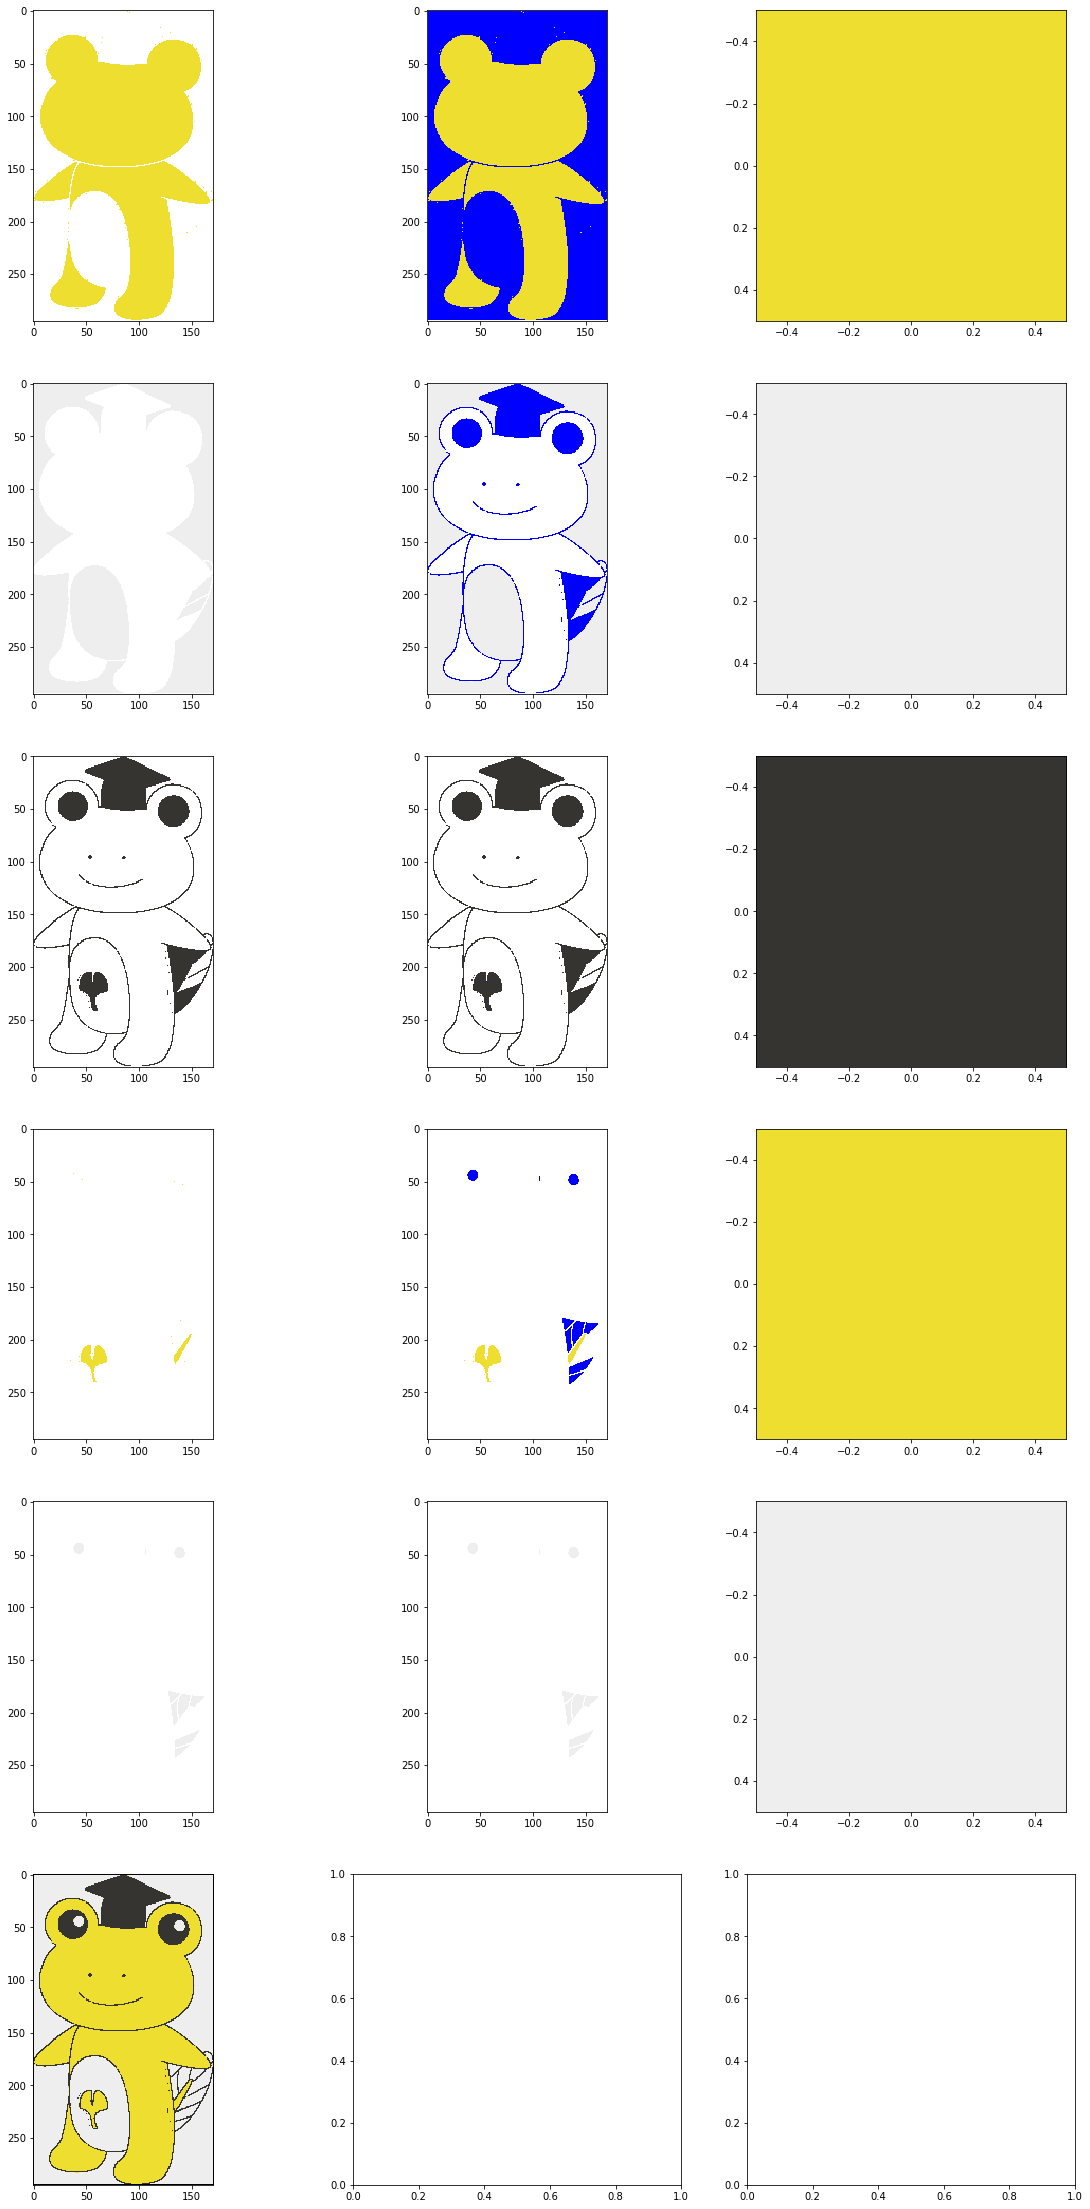

In [6]:
import os

os.makedirs("way1", exist_ok=True)

#####live#####
def punch_hole(stencils, indexes, colors, height, width, hole_indexes, color_index):#ndex_listsの第一成分のこと
    plate = np.ones((height, width))
    for i in range(len(hole_indexes)):
        hole_index = hole_indexes[i]
        for j in range(len(indexes[color_index])):
            if (indexes[color_index][j] >= hole_index):
                punch = np.where(stencils[color_index][j] == hole_index, 0, 1)
                plate = plate * punch #plateの0の部分が穴
                break
    
    return [plate, colors[color_index]]


def greedy_arrangement(colors, indexes, max_index):
    check_list = np.zeros(max_index)
    cnt = 0
    punch_list = []
    while(np.min(check_list) == 0):
        index = 1
        for i in range(len(indexes)):
            hole_indexes = []
            while(index <= indexes[i][-1]):
                if (check_list[index-1] == 1):
                    index += 1
                    continue
                delayed = False #Trueなら遅延確定
                dep = dependency_list[index-1]
                for j in range(len(dep)):
                    if (check_list[dep[j]-1] == 0):
                        delayed = True
                        print(index, "delayed!", dep)
                        break
                if (delayed == False):
                    #check_list[index-1] = 1 #この段階でcheckしちゃダメ
                    hole_indexes.append(index)
                    #print(index, "checked!")
                index += 1
            print(hole_indexes)
            if (len(hole_indexes) == 0):
                continue
            cnt+=1
            for h in range(len(hole_indexes)):
                check_list[hole_indexes[h]-1] = 1
                print(hole_indexes[h], "checked!")
            p = punch_hole(hole_lists_dummy, indexes, colors, dst_mask[0].shape[0], dst_mask[0].shape[1], hole_indexes, i)
            punch_list.append(p)
        #print(check_list)
    return cnt, punch_list

def max_area(stencils):
    a = copy.deepcopy(stencils)
    for i in range(1, len(a)):
        s = a[i][0]
        for j in range(0, i):
            for x in range(s.shape[0]):
                for y in range(s.shape[1]):
                    if (s[x][y] == 0 and a[j][0][x][y] == 1):
                        a[j][0][x][y] = 2
    return a

count, naive_stencil_list = greedy_arrangement(extracted_colors, index_list, max_index)
print("total number", count)

stencil_list = max_area(naive_stencil_list)

completion = np.zeros((dst_mask[0].shape[0], dst_mask[0].shape[1], 3)) #完成図

fig, axs = plt.subplots(len(stencil_list) + 1, 3, figsize=(20, 40))
for i in range(len(stencil_list)):
    #axs[i][0].imshow(punch_list[i][0])
    colored_stencil = (np.array([stencil_list[i][1], [255,255,255], [255,255,255]]))[stencil_list[i][0].astype(int)]
    axs[i][0].imshow(cv2.cvtColor(colored_stencil.astype(np.uint8), cv2.COLOR_BGR2RGB))
    colored_stencil = (np.array([stencil_list[i][1], [255,255,255], [255,0,0]]))[stencil_list[i][0].astype(int)]
    axs[i][1].imshow(cv2.cvtColor(colored_stencil.astype(np.uint8), cv2.COLOR_BGR2RGB))
    axs[i][2].imshow(cv2.cvtColor(stencil_list[i][1].reshape([1,1,-1]).astype(np.uint8), cv2.COLOR_BGR2RGB))
    
    for p in range(dst_mask[0].shape[0]):
        for q in range(dst_mask[0].shape[1]):
            if (stencil_list[i][0][p][q] == 0):
                completion[p][q] = stencil_list[i][1]
    cv2.imwrite("way1/stencil{}.png".format(i),colored_stencil.astype(np.uint8))
axs[len(stencil_list)][0].imshow(cv2.cvtColor(completion.astype(np.uint8), cv2.COLOR_BGR2RGB))
cv2.imwrite("way1/output.png",completion.astype(np.uint8))

In [7]:
dst_mask[0]

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]])

In [60]:
a19 = np.where(hole_lists_dummy[0][1] == 19, 1, 0)
a59 = np.where(hole_lists_dummy[2][0] == 59, 1, 0)
np.unique(a19 - a59)

array([0])

In [30]:
np.where(island_lists[0][0] == 4.1)

NameError: name 'island_lists' is not defined

In [65]:
np.unique(colored_layers[0] + colored_layers[2])

array([0., 1.])

In [89]:
print(island_labels[0][550, 700])
print(island_labels[0][525, 700])
np.where(island_labels[0][400:600, 650:] == 4)

2.0
5.0


(array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,
         5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,  9,  9,
         9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11]),
 array([25, 26, 27, 28, 29, 30, 31, 32, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 25, 26, 27, 28, 29,
        30, 31, 32, 33, 34, 25, 26, 27, 28, 29, 30, 31, 32, 26, 27, 28, 29,
        30, 31, 32, 28, 29, 30, 31, 28, 29, 30, 31, 28, 29, 30, 31, 27, 28,
        29, 30, 31, 25, 26, 27, 28, 29, 30, 31, 25, 26, 27, 28, 29, 30]))

In [9]:
np.unique(updated_weight)

array([0])